In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sjoert.stellar
import pandas as pd
import os
from tqdm import tqdm
from astropy import coordinates as coord
from scipy.optimize import curve_fit
import forced_phot as fp #import flux_jy, chi2, gaussian, chi2_peak_finder
from scipy.constants import h,c,k
import json

sjoertpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares'

## TO DO
* plot de lightcurves op een verticale manier (3 plots boven elkaar: g, r, i - maak de kleuren ook de kleur van de filter (i bruin)). Zet hier ook de uncleaned data in in het grijs met lage zorder en alpha
    * save de plots in hun bijbehorende folder. Zo heb je maar 1 png per folder.

* Bij het peak finden willen stellen dat de piek op zijn laatst in juli 2022 ligt. Met een tijdstap van 5 dagen. (maak dus van de chi2 zoektoch ook een arange/linspace ipv de datapunten)/

* Anomaly detection?? Local Outlier Factor? Isolation Forest?

In [2]:
PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)
DATAPATH = os.path.join(PATH,'Data')
CODEPATH = os.path.join(PATH,'Code')
columns = ['sindex', 'field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc', 'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime', 'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd', 'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr', 'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap', 'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag', 'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart', 'refjdend', 'procstatus']
dtypes = [(columns[x],float) for x in range(len(columns))]
dtypes[4] = ('filter',r'U8')


## Preprocessing

In [49]:
testdir = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo'
testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo\ZTF18abjjkeo_clean_data.json'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aauosxv\clean_ZTF_r_batchfp_req0000338734_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aavummp\clean_ZTF_r_batchfp_req0000338750_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aajupnt\clean_ZTF_r_batchfp_req0000338755_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo\clean_g_and_rbatchfp_req0000338730_lc.txt'
unclean_data_full = pd.DataFrame(np.genfromtxt(os.path.join(testdir,os.listdir(testdir)[0]),skip_header=53,dtype=dtypes))

def preprocess_clean_data(datapath):
    """Preprocess a cleaned json file given its path. The full clean data will be read in. A mask that can filter out all
       ZTF_i measurements is created. Flux measurements and its errors are converted to uJy and the DataFrame is appended to only retain this
       information. Time is normalized to the minimal Julian Date of a measurement in ZTF_g or ZTF_r for the purposes of lessening the strain
       on the fitting procedure later on (smaller numbers). 

    Args:
        datapath (string): Path to clean data.

    Returns:
        data (DataFrame): pandas DataFrame of full, transformed clean data.
        ztf_name (string): string containing the ZTF identifier of the transient.
        no_i_mask (array_like): mask array that can filter out all ZTF_i filter measurements.
        time_zeropoint (float): julian date of the zeropoint used in this instance, saved since it will differ for each clean data file. 
    """
    data = pd.read_json(datapath) #read in the clean data
    data.sort_values('time',inplace=True) #sort the data by time for plotting reasons later on
    ztf_name = os.path.split(datapath)[-1].split('_')[0] #save the ZTF name using the clean data naming convention
    no_i_mask = data['filter'] != 'ZTF_i' #create the ZTf_i mask
    flux,err = fp.flux_jy(data) #convert the flux and its errors to uJY
    err = np.clip(err,0.01*flux,np.inf) # clip the errors to be at least 1% of the flux
    data['flux'] = flux.values
    data['flux_unc'] = err.values
    time_zeropoint = np.min(data['time'][no_i_mask]) #find the zeropoint for time to be used here
    time_mjd = data['time'] - time_zeropoint
    data['time'] = time_mjd.values #transform time column

    return data, ztf_name, no_i_mask, time_zeropoint

testdata_full, ztf_name, no_i_mask, time_zeropoint = preprocess_clean_data(testpath)
testdata = testdata_full[no_i_mask]
print(ztf_name)
greenmask = (testdata['filter'] == 'ZTF_g').values
flux, err, time = testdata[['flux','flux_unc','time']].T.to_numpy(dtype=np.float64)
testdata


ZTF18abjjkeo


,time,flux,flux_unc,zeropoint,filter
388,0.000000,-1.344564,6.445607,26.0676,ZTF_g
842,2.903044,2.424660,3.506866,26.0978,ZTF_r
0,2.917130,0.944436,3.200221,26.0583,ZTF_g
389,2.934757,3.080319,3.340502,26.0819,ZTF_g
1,6.911632,1.040244,3.363581,26.0003,ZTF_g
...,...,...,...,...,...
387,1797.921030,9.290255,13.016308,26.1872,ZTF_g
773,1797.922477,-0.386905,12.884028,26.2025,ZTF_g
1274,1797.959757,2.709345,7.771195,26.1818,ZTF_r
774,1800.003067,6.206070,8.058415,26.1449,ZTF_g


## Plotting unfitted data, both cleaned and uncleaned.

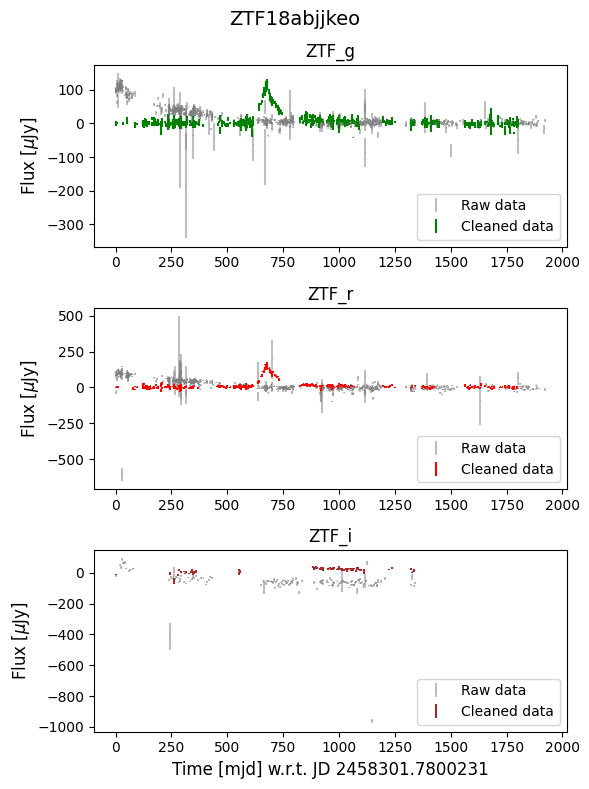

In [45]:
testpath_unclean = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aajupnt\batchfp_req0000338755_lc.txt'

def load_unclean_data(path):
    columns = ['sindex', 'field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc', 'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime', 'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd', 'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr', 'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap', 'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag', 'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart', 'refjdend', 'procstatus']
    dtypes = [(columns[x],float) for x in range(len(columns))]
    dtypes[4] = ('filter',r'U8')
    data = pd.DataFrame(np.genfromtxt(path,skip_header=53,dtype=dtypes))
    data['jd'] = data['jd'] - time_zeropoint
    return data

testdata_unclean = load_unclean_data(testpath_unclean)

def plot_clean_unclean_data(clean_data,unclean_data):
    unclean_data = unclean_data[unclean_data['forcediffimfluxunc'] > 0]
    clean_flux, clean_err, clean_time = clean_data[['flux','flux_unc','time']].T.to_numpy(dtype=np.float64)
    raw_flux, raw_err, raw_time = unclean_data[['forcediffimflux','forcediffimfluxunc','jd']].T.to_numpy(dtype=np.float64)
    raw_flux = sjoert.stellar.mag2flux(unclean_data['zpdiff']) * 1e6 * raw_flux
    raw_err = sjoert.stellar.mag2flux(unclean_data['zpdiff']) * 1e6 * raw_err
    raw_flux,raw_err,raw_time = raw_flux,raw_err,raw_time

    clean_filtermasks = [(clean_data['filter'] == 'ZTF_g'), (clean_data['filter'] == 'ZTF_r'), (clean_data['filter'] == 'ZTF_i')]
    raw_filtersmasks = [(unclean_data['filter'] == 'ZTF_g'), (unclean_data['filter'] == 'ZTF_r'), (unclean_data['filter'] == 'ZTF_i')]
    colors = ['green','red','brown']
    names = ['ZTF_g','ZTF_r','ZTF_i']

    fig,axes = plt.subplots(nrows=3,sharex=True,figsize=(6,8))
    plt.suptitle(ztf_name,fontsize=14)
    axes[0].xaxis.set_tick_params(which='both', labelbottom=True)
    axes[1].xaxis.set_tick_params(which='both', labelbottom=True)
    for i,ax in enumerate(axes):
        ax.set_title(names[i])
        ax.errorbar(raw_time[raw_filtersmasks[i]],raw_flux[raw_filtersmasks[i]],raw_err[raw_filtersmasks[i]],fmt=',',alpha=0.5,c='gray',label='Raw data')
        ax.errorbar(clean_time[clean_filtermasks[i]],clean_flux[clean_filtermasks[i]],clean_err[clean_filtermasks[i]],fmt=',',c=colors[i],label='Cleaned data')
        ax.legend(loc='lower right')
        ax.set_ylabel(r'Flux [$\mu$Jy]',fontsize=12)
    
    plt.xlabel(f'Time [mjd] w.r.t. JD {time_zeropoint}',fontsize=12)
    fig.tight_layout()
    plt.show()

plot_clean_unclean_data(testdata_full,testdata_unclean)

# time_unclean, flux_unclean, err_unclean,zeropoint_unclean = testdata_unclean['jd'].values - time_zeropoint, testdata_unclean['forcediffimflux'].values, testdata_unclean['forcediffimfluxunc'].values,testdata_unclean['zpdiff'].values
# zp_unclean = sjoert.stellar.mag2flux(zeropoint_unclean)
# flux_unclean = zp_unclean * flux_unclean * 1e6
# err_unclean = zp_unclean * err_unclean * 1e6
# wrong_err_mask = (err_unclean > 0)
# unclean_green_mask, unclean_red_mask,unclean_i_mask = (testdata_full['filter'] == 'ZTF_g'), (testdata_full['filter'] == 'ZTF_r'), (testdata_full['filter'] == 'ZTF_i')

## Fitting

### First, some more preprocessing

In [6]:

#Source: http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=Palomar&gname2=ZTF&asttype=
g_center = c/ (4746.48 * 1e-10)
r_center = c / (6366.38 * 1e-10)

chi2_results, peak_ind, peak_position_guess, peak_guess = fp.chi2_peak_finder(flux,err,time,time_zeropoint)
print(f"Peak guess: {peak_guess} at time {peak_position_guess}.")

time_mask = (time > (peak_position_guess - 365)) & (time < (peak_position_guess+365*2)) #these are the times we will be fitting on

#values for fitting
flux_fit,err_fit,time_fit,filters_fit = flux[time_mask],err[time_mask],time[time_mask],testdata['filter'][time_mask].to_numpy()

#frequency array and "central" frequency for blackbody ratio correction
v1 = filters_fit.copy()
v1[v1 == 'ZTF_g'] = g_center
v1[v1 == 'ZTF_r'] = r_center
v1 = v1.astype(np.float64)
v0 = np.average([g_center,r_center],weights=[np.sum(filters_fit=='ZTF_g'),np.sum(filters_fit=='ZTF_r')])

#Initial guesses and boundings for fitting in order: Fp, peak_pos, sigma, tau_dec, F0, T
guesses = [np.log10(np.max(flux_fit)),peak_position_guess,1,2.5,1,4]
boundings = ([1,peak_position_guess-100,0,0,0,3],[np.log10(np.max(flux_fit*2)),peak_position_guess+100,4,4,np.median(flux_fit),5]) 


Peak guess: 83.26198124110684 at time 660.0.


### Old
-------------------------------

In [7]:
# time = testdata['time']
# flux,err = testdata['flux'],testdata['flux_unc']
# maxtime = time.iloc[np.argmax(flux)]
# maxflux = np.max(flux)

# def gauss(x,a,b,c,d):
#     return a * np.exp(-(np.square(x-b)/(2*c**2)))

# def exp_decay(x,a,b,c,d):
#     return a * np.exp(-b * x)

# def gauss_exp_comb(x,b,c,d):
#     #xrel = x - max_time
#     #masks zijn dan xrel <=0 en x >0
#     #eigenlijk beter: def model(x, *p) dan kan p gewoon een array van arbitraire lengte.
#     #verder in log: tau_dec = 10^(p[1]) en je kan bounds geven, tau_dec is ipc rond de 10
#     #sigma_rise = 10^(p[2])
#     #Fp = 10^(p[3]) maakt niet uit of dit 10 of e of 3 is, 10 is robuuster (intuitiever)
#     #ook nog een offset parameter meegeven zodat waardes <0 ook meegenomen worden 
#     #alpha: spectral index is p[5]  
#     # dus niet return zoals hieronder maar dat gaat in z'n geheel nog keer (v_i/v_0)^alpha en v_i is een array van centrals van g of r maar dat is verschillend 
#     #per datapunt - elk datapunt heeft een tijd en bijbehorende filter (waar die vandaan komt) en zo kan je v_i construeren.
#     #uiteindelijk zijn dus fittable: 6 parameters. alpha is te interpreten als - phot. kleur (met een factor 2.5 ergens van de magnitudes). Alpha /> 2 (dat is BB) of arbitrair negatief
#     #zijn
#     #zet ook een condition dat alpha niet gefit wordt als v_i bestaat uit alleen maar dezelfde waarde (ofwel je fit maar in 1 band)
#     #ADDENDUM/ERRATUM: we gaan weg van alpha en doen het anders. We pakken B_v(T)/B_v_0(T) waar en v_0 is je referentie 0 (tussen r en g). Zet bound op temperatuur van 1000K > T > 10^5 K
#     #Verder: T = 10^(p[5])
#     #robuust piek vinden: google robust peak finding. je kan ook driehoek (10 dagen rise, 10 dagen decay bv) fitten en de beste chi^2 vinden

#     return np.piecewise(x,[x <= 0,x>0],[lambda x:maxflux * np.exp(-(np.square(x-b)/(2*c**2))), lambda x:maxflux * np.exp(-d * x)])

# popt,pcov = curve_fit(gauss_exp_comb,time.values-time.iloc[np.argmax(flux)],flux.values,p0=[1,1,1e-2]) 
# moretimes = np.linspace(min(time),max(time),1000) 
# fit = gauss_exp_comb(moretimes-time.iloc[np.argmax(flux)],*popt)

# print(popt,np.diagonal(pcov),'\nrelative error: ',np.diagonal(pcov)/popt)

# plt.errorbar(time,flux,err,fmt='.',c='black',label='Data')
# plt.plot(moretimes,fit,label='Piecewise fit')
# plt.xlabel("Time (jd)")
# plt.ylabel("Flux (mJy)")
# plt.title("Peak not fittable (ZTF18abjjkeo, R-band)")
# plt.legend()
# plt.show()

### New, but not complete

Popt: ['log10(Fp) = 2.072023062865296', 'peak_position = 676.476842850629', 'log10(sigma_rise) = 1.3355611695780258', 'log10(tau_dec) = 1.8075500676592573', 'F0 = 2.774483903948932', 'log10(T) = 3.8086585689693346'] 
Errors [1.26242324e-05 2.85291755e-01 2.53684002e-04 1.32532202e-04
 5.36621983e-02 1.63255116e-05] 
Relative error:  [6.09270843e-06 4.21731738e-04 1.89945626e-04 7.33214556e-05
 1.93413262e-02 4.28642036e-06]


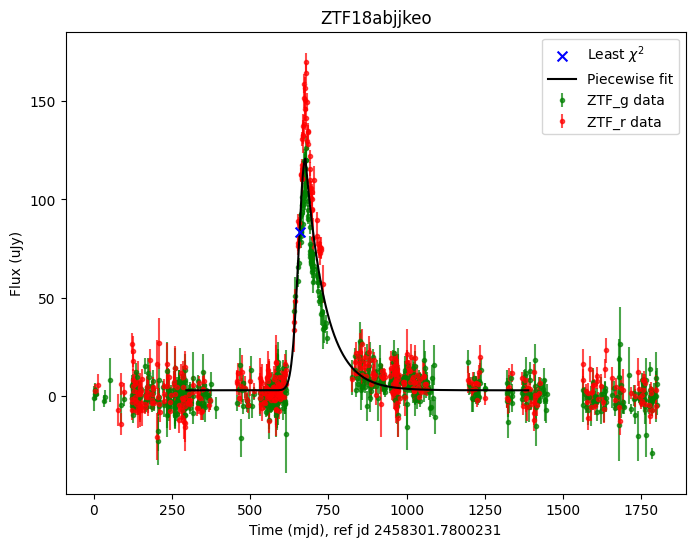

In [15]:
def BB(nu,T):
    #Blackbody spectrum for a certain frequency given in Hz, not an array of values
    factor = 2*h*np.power(nu,3)/(c**2)
    exponent = (h*nu)/(k*T)
    return factor /(np.exp(exponent)-1)

def BB_ratio(T):
    return BB(v1,T)/BB(v0,T)

def BB_ratio_green(T):
    return BB(g_center,T)/BB(v0,T)

def BB_ratio_red(T):
    return BB(r_center,T)/BB(v0,T)

#With BB temperature correction, used for fitting to ZTF_g and ZTF_r data
def gauss_exp_fit(t,*p):
    Fp = 10**p[0]
    peak_position = p[1]
    sigma_rise = 10**p[2]
    tau_dec = 10**p[3]
    F0 = p[4]
    T = 10**p[5]

    trel = t - peak_position
    gaussian = lambda t: Fp * np.exp(-(np.square(t-peak_position)/(2*sigma_rise**2))) + F0
    exp_decay = lambda t: Fp * np.exp(-(t-peak_position)/tau_dec) + F0

    function = np.piecewise(t,[trel <= 0,trel>0],[gaussian, exp_decay])
    return function * BB_ratio(T)

#without the BB correction, used for plotting. 
def gauss_exp(t,*p):
    Fp = 10**p[0]
    peak_position = p[1]
    sigma_rise = 10**p[2]
    tau_dec = 10**p[3]
    F0 = p[4]
    T = 10**p[5]

    trel = t - peak_position
    gaussian = lambda t: Fp * np.exp(-(np.square(t-peak_position)/(2*sigma_rise**2))) + F0
    exp_decay = lambda t: Fp * np.exp(-(t-peak_position)/tau_dec) + F0

    # trel2 = t - t[np.argmin(gaussian(t)-Fp)]
    # print(trel2)
    function = np.piecewise(t,[trel <= 0,trel>0],[gaussian, exp_decay])
    return function 

    
popt,pcov,info_dict,_,_ = curve_fit(gauss_exp_fit,time_fit,flux_fit,p0=guesses,bounds=boundings,sigma=err_fit,
                                    full_output=True) 

names = ["log10(Fp)","peak_position","log10(sigma_rise)","log10(tau_dec)","F0","log10(T)"]
display = [f"{names[i]} = {opt}" for i,opt in enumerate(popt)]
print("Popt:",display,'\nErrors',np.diagonal(pcov),'\nRelative error: ',np.diagonal(pcov)/popt)

# time_fit -= popt[1]
# time -= popt[1]

moretimes = np.linspace(min(time_fit),max(time_fit),2000)
fit = gauss_exp(moretimes,*popt) #fit it to a function that doesn't have the BB ratio
# fit *= BB_ratio_green(10**popt[-1]) #for green visual
# fit *= BB_ratio_red(10**popt[-1]) #for red visual

# time = time -  popt[2]

plt.figure(figsize=(8,6))
plt.errorbar(time[greenmask],flux[greenmask],err[greenmask],fmt='.',c='green',label='ZTF_g data',zorder=-1,alpha=0.7)
plt.errorbar(time[~greenmask],flux[~greenmask],err[~greenmask],fmt='.',c='red',label='ZTF_r data',zorder=-1,alpha=0.7)
# plt.scatter(time,flux,s=5,c='black',label='Data')
plt.scatter(peak_position_guess,peak_guess,s=50,marker='x',c='blue',zorder=10,label=r'Least $\chi^2$')
# plt.scatter(popt[1],10**popt[0],s=50,marker='x',c='pink',zorder=10,label=r'Fitted peak',alpha=0.9)

plt.plot(moretimes,fit,label='Piecewise fit',zorder=9,c='black')
# plt.vlines(popt[1],0,150,label='Found peak',colors='red')
plt.xlabel(f"Time (mjd), ref jd {time_zeropoint}")
plt.ylabel("Flux (uJy)")
plt.title("ZTF18abjjkeo")
plt.legend()  
plt.show()

# print(10**popt[0],np.max(fit)) #these dont match exactly due to introducing more times.
# print(fp.chi2(flux,err,model_fit=gauss_exp_fit(moretimes,*popt)))
# print(time_fit,time[peak_ind])

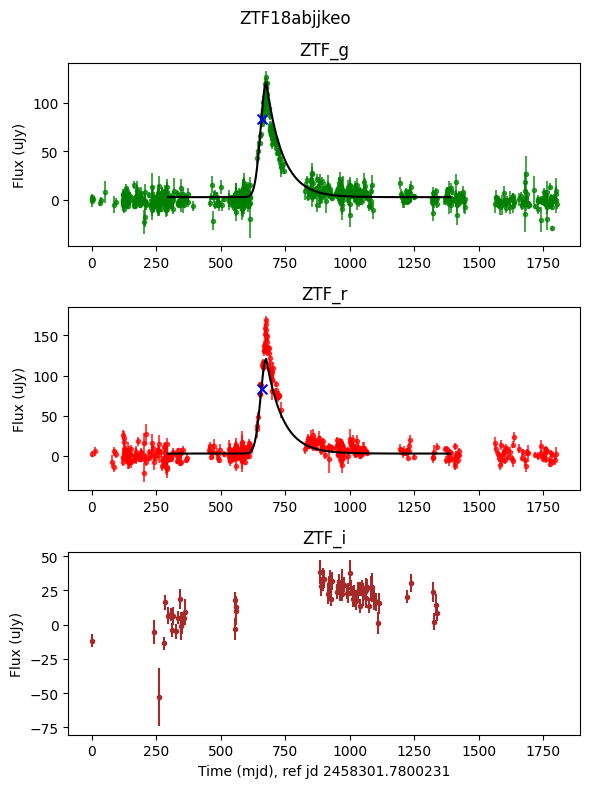

In [48]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,sharex=True,figsize=(6,8))
#dit werkt nog niet omdat we niet een goeie unclean data hebben opgeslagen
# greenmask_full = unclean_data_full['filter'] == 'ZTF_g'
# unclean_flux,unclean_err = fp.flux_jy()
# ax1.errorbar(unclean_data_full['jd'][greenmask_full],unclean_data_full['forcediffimflux'][greenmask_full],testdata_full['flux_unc'][greenmask_full],fmt='.',c='gray',label='unclean',zorder=-1,alpha=0.2)
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax2.xaxis.set_tick_params(which='both', labelbottom=True)

ax1.errorbar(time[greenmask],flux[greenmask],err[greenmask],fmt='.',c='green',label='ZTF_g data',zorder=-1,alpha=0.7)
ax2.errorbar(time[~greenmask],flux[~greenmask],err[~greenmask],fmt='.',c='red',label='ZTF_r data',zorder=-1,alpha=0.7)
# plt.scatter(time,flux,s=5,c='black',label='Data')
ax1.scatter(peak_position_guess,peak_guess,s=50,marker='x',c='blue',zorder=10,label=r'Least $\chi^2$')
ax2.scatter(peak_position_guess,peak_guess,s=50,marker='x',c='blue',zorder=10,label=r'Least $\chi^2$')
# ax1.scatter(popt[1],10**popt[0],s=50,marker='x',c='pink',zorder=10,label=r'Fitted peak',alpha=0.9)
# ax2.scatter(popt[1],10**popt[0],s=50,marker='x',c='pink',zorder=10,label=r'Fitted peak',alpha=0.9)

ax1.plot(moretimes,fit,label='Piecewise fit',zorder=9,c='black')
ax2.plot(moretimes,fit,label='Piecewise fit',zorder=9,c='black')

#This is color corrected with a BB ratio of only green and only red. As seen in the cells below this improves the chi2 greatly on a per filter
#basis but greatly worsens it on the combined data.
# ax1.plot(moretimes,fit*BB_ratio_green(10**(popt[-1])),label='Piecewise fit',zorder=9,c='black') 
# ax2.plot(moretimes,fit*BB_ratio_red(10**(popt[-1])),label='Piecewise fit',zorder=9,c='black')

ax3.errorbar(testdata_full['time'][~no_i_mask],testdata_full['flux'][~no_i_mask],testdata_full['flux_unc'][~no_i_mask],fmt='.',c='brown')

# plt.vlines(popt[1],0,150,label='Found peak',colors='red')
plt.xlabel(f"Time (mjd), ref jd {time_zeropoint}")
ax1.set_ylabel("Flux (uJy)")
ax2.set_ylabel("Flux (uJy)")
ax3.set_ylabel("Flux (uJy)")
ax1.set_title("ZTF_g")
ax2.set_title("ZTF_r")
ax3.set_title("ZTF_i")
plt.suptitle("ZTF18abjjkeo")
# ax1.legend()    
# ax2.legend()    
fig.tight_layout()
plt.show()

In [10]:
fit_chi2 = gauss_exp(time,*popt)
redmask = np.invert(greenmask)
chi2_green = fp.chi2(flux[greenmask],err[greenmask],fit_chi2[greenmask])
chi2_red = fp.chi2(flux[redmask],err[redmask],fit_chi2[redmask])
chi2_tot = fp.chi2(flux,err,fit_chi2)

print(f"chi2 total: {chi2_tot}, chi2 on ZTF_g: {chi2_green} and chi2 on ZTF_r: {chi2_red}.")
print(chi2_red+chi2_green)

fit_chi2_green = fit_chi2 * BB_ratio_green(10**(popt[-1]))
chi2_green_2 = fp.chi2(flux[greenmask],err[greenmask],fit_chi2_green[greenmask])
chi2_red_2 = fp.chi2(flux[redmask],err[redmask],fit_chi2_green[redmask])
chi2_tot_2 = fp.chi2(flux,err,fit_chi2_green)
print('\nNow with green temperature correction:')
print(f"chi2 total : {chi2_tot_2}, chi2 on ZTF_g: {chi2_green_2} and chi2 on ZTF_r: {chi2_red_2}.")
print(chi2_red_2+chi2_green_2)


fit_chi2_red = fit_chi2 * BB_ratio_red(10**(popt[-1]))
chi2_green_3 = fp.chi2(flux[greenmask],err[greenmask],fit_chi2_red[greenmask])
chi2_red_3 = fp.chi2(flux[redmask],err[redmask],fit_chi2_red[redmask])
chi2_tot_3 = fp.chi2(flux,err,fit_chi2_red)
print('\nNow with red temperature correction:')
print(f"chi2 total : {chi2_tot_3}, chi2 on ZTF_g: {chi2_green_3} and chi2 on ZTF_r: {chi2_red_3}.")
print(chi2_red_3+chi2_green_3)

print()
print(f"Sum of best green and red: {chi2_green_2} + {chi2_red_3} = {chi2_green_2+chi2_red_3}")

chi2 total: 4212.008281798574, chi2 on ZTF_g: 2378.860703746882 and chi2 on ZTF_r: 1833.147578051693.
4212.008281798575

Now with green temperature correction:
chi2 total : 5057.002907446523, chi2 on ZTF_g: 1468.696144422285 and chi2 on ZTF_r: 3588.3067630242376.
5057.002907446523

Now with red temperature correction:
chi2 total : 7766.035351527309, chi2 on ZTF_g: 6883.960644117113 and chi2 on ZTF_r: 882.0747074101976.
7766.03535152731

Sum of best green and red: 1468.696144422285 + 882.0747074101976 = 2350.7708518324825


## Saving the parameters in a json file.

In [11]:
deg_freedom = len(flux) - (len(popt) + 1) #degrees of freedom is no. points - minus parameters (the fitted ones + v0)
print(deg_freedom)

def save_params_to_json(popt,pcov,v0,chi2,dof,ztf_name=None,savepath=None):
    errs = np.diag(pcov)
    params_names = ['Fp', 'peak_position', 'sigma_rise',
       'tau_dec', 'F0', 'T', 'v0']
    
    params = [10**p if 'log10' in names[i] else p for i,p in enumerate(popt)]
    param_errs = [np.log(10)*e*params[i] if 'log10' in names[i] else e for i,e in enumerate(errs)]
    params.append(v0) #since v0 doesn't have an error(?), add it only now. 
    param_errs.append(0)

    units = ['uJy','mjd','days','days','uJy','K','Hz']
    full_dict = {'parameters':params,'errors':param_errs,'chi2':chi2,'dof':dof,'names':params_names,'units':units}
    if savepath is not None:
        filename = ztf_name + '_parameters'
        with open(os.path.join(savepath,filename),'w') as file:
            json.dump(full_dict,file,indent = 4)
    return full_dict

save_params_to_json(popt,pcov,v0,chi2_tot,deg_freedom,ztf_name,testdir)

1202


{'parameters': [118.03833173107495,
  676.476842850629,
  21.655148666101557,
  64.20222328042996,
  2.774483903948932,
  6436.630354046163,
  572476790345318.4],
 'errors': [0.0034311818155172004,
  0.2852917547184771,
  0.012649400383794935,
  0.01959237885933807,
  0.05366219826726624,
  0.24195859733901956,
  0],
 'chi2': 4212.008281798574,
 'dof': 1202,
 'names': ['Fp', 'peak_position', 'sigma_rise', 'tau_dec', 'F0', 'T', 'v0'],
 'units': ['uJy', 'mjd', 'days', 'days', 'uJy', 'K', 'Hz']}

In [12]:
with open(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo\ZTF18abjjkeo_parameters') as file:
    param_data = json.load(file)

params = np.array(param_data['parameters'])
param_errs = np.array(param_data['errors'])
# print(params)
relative_errs = param_errs/params

print(relative_errs,np.diagonal(pcov)/popt)
param_data

[2.90683693e-05 4.21731738e-04 5.84129002e-04 3.05166673e-04
 1.93413262e-02 3.75908797e-05 0.00000000e+00] [6.09270843e-06 4.21731738e-04 1.89945626e-04 7.33214556e-05
 1.93413262e-02 4.28642036e-06]


{'parameters': [118.03833173107495,
  676.476842850629,
  21.655148666101557,
  64.20222328042996,
  2.774483903948932,
  6436.630354046163,
  572476790345318.4],
 'errors': [0.0034311818155172004,
  0.2852917547184771,
  0.012649400383794935,
  0.01959237885933807,
  0.05366219826726624,
  0.24195859733901956,
  0],
 'chi2': 4212.008281798574,
 'dof': 1202,
 'names': ['Fp', 'peak_position', 'sigma_rise', 'tau_dec', 'F0', 'T', 'v0'],
 'units': ['uJy', 'mjd', 'days', 'days', 'uJy', 'K', 'Hz']}

In [13]:
exclude = ['chi2','dof','names']
param_df_dict = {k: param_data[k] for k in set(list(param_data.keys())) - set(exclude)}
param_df_dict
# pd.DataFrame(param_df_dict,index=param_data['names'])

{'parameters': [118.03833173107495,
  676.476842850629,
  21.655148666101557,
  64.20222328042996,
  2.774483903948932,
  6436.630354046163,
  572476790345318.4],
 'errors': [0.0034311818155172004,
  0.2852917547184771,
  0.012649400383794935,
  0.01959237885933807,
  0.05366219826726624,
  0.24195859733901956,
  0],
 'units': ['uJy', 'mjd', 'days', 'days', 'uJy', 'K', 'Hz']}